<a href="https://colab.research.google.com/github/sayakpaul/Adversarial-Examples-in-Deep-Learning/blob/master/Image_Adversaries_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contents of this notebook come from: https://adversarial-ml-tutorial.org/introduction/.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [15]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

In [ ]:
!wget https://adversarial-ml-tutorial.org/introduction/pig.jpg

In [3]:
def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

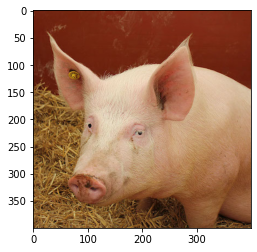

In [4]:
sample_image = show_image("pig.jpg")

In [5]:
!wget -q https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
!tar -xf noisy_student_efficientnet-b0.tar.gz

In [ ]:
!wget -q https://raw.githubusercontent.com/yixingfu/tensorflow/updateweights/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
!python efficientnet_weight_update_util.py --model b0 --ckpt \
       noisy_student_efficientnet-b0/model.ckpt --o efficientnetb0.h5

In [8]:
# Load pre-trained networks
resnet50 = tf.keras.applications.ResNet50(weights="imagenet")
enb0 = tf.keras.applications.EfficientNetB0(weights="imagenet")
enb0_nst = tf.keras.applications.EfficientNetB0(weights="efficientnetb0.h5")

In [10]:
def preprocess_image(image_pixels):
    image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

In [ ]:
# Preprocess the image
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image(sample_image)

In [12]:
# Run inference ResNet50
preds = resnet50.predict(preprocessed_image)
print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

Predicted: [('n02395406', 'hog', 0.99968374), ('n02396427', 'wild_boar', 0.00031595054), ('n03935335', 'piggy_bank', 9.8273716e-08)]


In [13]:
# Run inference EfficientNetB0 (ImageNet)
preds = enb0.predict(preprocessed_image)
print('Predicted:', tf.keras.applications.efficientnet.decode_predictions(preds, top=3)[0])

Predicted: [('n02395406', 'hog', 0.8986302), ('n02396427', 'wild_boar', 0.032319155), ('n01704323', 'triceratops', 0.0011883618)]


In [14]:
# Run inference EfficientNetB0 (NST)
preds = enb0_nst.predict(preprocessed_image)
print('Predicted:', tf.keras.applications.efficientnet.decode_predictions(preds, top=3)[0])

Predicted: [('n02395406', 'hog', 0.9445068), ('n02396427', 'wild_boar', 0.024005855), ('n02397096', 'warthog', 0.00051430723)]


In [16]:
# Class index
preds.argmax()

341

In [17]:
!wget -q https://raw.githubusercontent.com/USCDataScience/dl4j-kerasimport-examples/master/dl4j-import-example/data/imagenet_class_index.json

In [18]:
# Parse the label
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[preds.argmax()])

hog


In [19]:
# Loss has to be very low here
cce = tf.keras.losses.SparseCategoricalCrossentropy()
loss = cce(
    tf.convert_to_tensor([341]),
    tf.convert_to_tensor(preds)
)
print(loss.numpy())

0.057092153


In [20]:
# The probability we got when we ran the last inference
np.exp(-loss.numpy())

0.944507

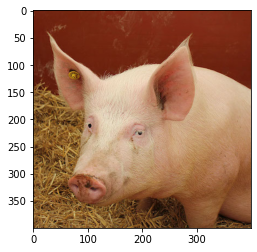

In [21]:
def preprocess_image_without(image_pixels):
    # image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

# Load and preprocess image but a but without any `preprocess_input`
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image_without(sample_image)

# Initialize the perturbation quantity
image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

In [22]:
# Clipping utility so that the pixel values stay within [0,1]
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

In [23]:
# Let's create an adversarial example
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [24]:
# Generate Adversarial Example for ResNet50
scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()

for t in range(50):
    plt.show()
    with tf.GradientTape() as tape:
        tape.watch(delta)
        inp = preprocess_input(image_tensor + delta)
        predictions = resnet50(inp, training=False)
        loss = - scc_loss(
                tf.convert_to_tensor([341]),
                predictions
            )
        if t % 5 == 0:
            print(t, loss.numpy())
            # plt.imshow(50*delta.numpy().squeeze()+0.5)
        
    # Get the gradients
    gradients = tape.gradient(loss, delta)
    
    # Update the weights
    optimizer.apply_gradients([(gradients, delta)])

    # Clip so that the delta values are within [0,1]
    delta.assign_add(clip_eps(delta))

0 -0.00041071087
5 -0.0010639727
10 -0.00533265
15 -0.06323115
20 -0.7693074
25 -3.4331908
30 -7.340926
35 -13.038242
40 -16.118187
45 -16.118193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


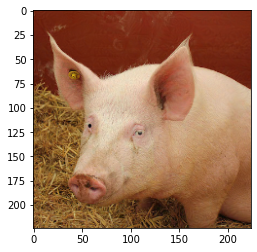

In [25]:
# See if the image changes
plt.imshow((image_tensor + delta).numpy().squeeze()/255)
plt.show()

In [26]:
# Generate prediction
perturbed_image = preprocess_input(image_tensor + delta)
preds = resnet50.predict(perturbed_image)
print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

Predicted: [('n01883070', 'wombat', 0.9999938), ('n02909870', 'bucket', 3.8295707e-06), ('n02454379', 'armadillo', 5.5668374e-07)]


The classifier generates wrong predictions even for slightest of perturbations. Let's put all of the above code together and create utility functions for quickly testing on new images. Note that in the above case, our class index was `341` for hog and to generlaize to other class (other than `hog`) of images we would need to supply the correct class indices to our method. 

In [27]:
def generate_adversaries(image_tensor, delta, model, true_class_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    for t in range(50):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = model(inp, training=False)
            loss = - scc_loss(
                    tf.convert_to_tensor([true_class_index]),
                    predictions
                )
            if t % 5 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [28]:
def perturb_image(image_path, true_class_index, model):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image_without(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = model.predict(preprocess_input(preprocessed_image))
    print('Predicted before adv.:', tf.keras.applications.imagenet_utils.decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries(image_tensor, delta, model, true_class_index)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    preds = model.predict(perturbed_image)
    print('Predicted:', tf.keras.applications.imagenet_utils.decode_predictions(preds, top=3)[0])

In [29]:
# Image comes from https://www.flickr.com/photos/bambe1964/7837618434/
!wget -q https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/example.jpg

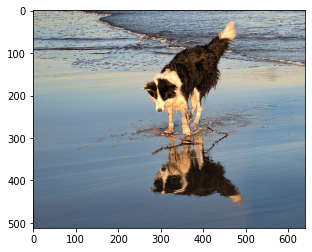

In [30]:
# Preview the image
plt.imshow(plt.imread("example.jpg"))
plt.show()

This fella is `Lakeland_terrier` and the class index in this case is `189`. Here's a handy little function to quickly find this out:

```python
for key, value in imagenet_classes.items():
    if imagenet_classes[key] == "Lakeland_terrier":
        print(key)
```

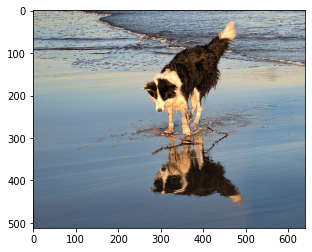

Predicted before adv.: [('n02095570', 'Lakeland_terrier', 0.3143305), ('n02102040', 'English_springer', 0.18979445), ('n02101388', 'Brittany_spaniel', 0.18742307)]
0 -1.1573787
5 -10.629698
10 -16.118187
15 -16.11819
20 -16.11819
25 -16.11819
30 -16.11819
35 -16.118193
40 -16.118193
45 -16.118193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


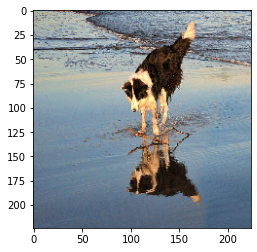

Predicted: [('n02102040', 'English_springer', 0.97401065), ('n02106166', 'Border_collie', 0.013876936), ('n02101388', 'Brittany_spaniel', 0.0057765422)]


In [31]:
# ResNet50
perturb_image("example.jpg", 189, resnet50)

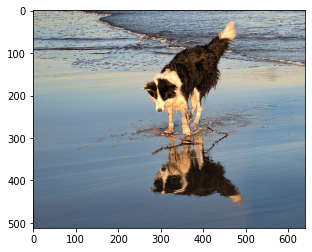

Predicted before adv.: [('n02100735', 'English_setter', 0.35577312), ('n02101388', 'Brittany_spaniel', 0.20054518), ('n02102177', 'Welsh_springer_spaniel', 0.13095953)]
0 -3.5944433
5 -6.9328494
10 -9.191999
15 -10.979104
20 -12.303162
25 -13.49832
30 -14.705996
35 -15.992272
40 -16.118097
45 -16.1181


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


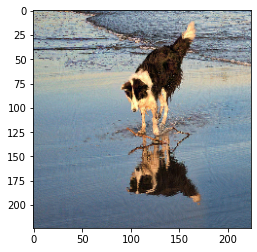

Predicted: [('n02101388', 'Brittany_spaniel', 0.9566194), ('n02091244', 'Ibizan_hound', 0.019950993), ('n02100735', 'English_setter', 0.018774172)]


In [32]:
# EfficientNetB0 (with ImageNet initialization)
perturb_image("example.jpg", 189, enb0)

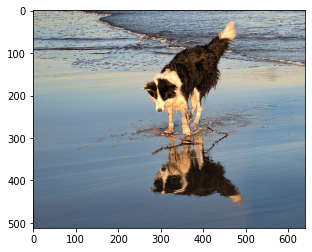

Predicted before adv.: [('n02102040', 'English_springer', 0.6601953), ('n02106166', 'Border_collie', 0.04607161), ('n02090622', 'borzoi', 0.031185148)]
0 -4.2066226
5 -8.195325
10 -11.163792
15 -13.311928
20 -14.999102
25 -16.118122
30 -16.118126
35 -16.118122
40 -16.118116
45 -16.118113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


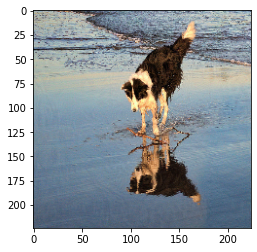

Predicted: [('n02102040', 'English_springer', 0.9973846), ('n02100735', 'English_setter', 0.00070606003), ('n02102177', 'Welsh_springer_spaniel', 0.00048336224)]


In [33]:
# EfficientNetB0 (with noisy student training initialization)
perturb_image("example.jpg", 189, enb0_nst)

The method works here as well. Let's now tackle targeted attacks. 

In [35]:
def generate_adversaries_targeted(image_tensor, delta, model,
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [40]:
def perturb_image(image_path, true, target, model):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image_without(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = model.predict(preprocess_input(preprocessed_image))
    print('Predicted before adv.:', tf.keras.applications.imagenet_utils.decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, model, true, target)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    preds = model.predict(perturbed_image)
    print('Predicted:', tf.keras.applications.imagenet_utils.decode_predictions(preds, top=3)[0])

Let's say we would want to perturbate the image of `hog` such that our classifier misclassifies it to be a `Lakeland_terrier`. Remember that the class index of `Lakeland_terrier` is `189` and the class index of `hog` is `341`.

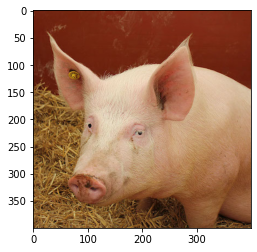

Predicted before adv.: [('n02395406', 'hog', 0.99968874), ('n02396427', 'wild_boar', 0.00031112912), ('n03935335', 'piggy_bank', 8.920516e-08)]
0 16.117785
20 16.115244
40 16.094204
60 13.447998
80 9.2348385
100 6.4456034
120 4.5434833
140 3.147447
160 1.9180658
180 0.90079355
200 0.007817745
220 -0.79713583
240 -1.5475984
260 -2.2402916
280 -2.8845518
300 -3.5297866
320 -4.146905
340 -4.748849


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


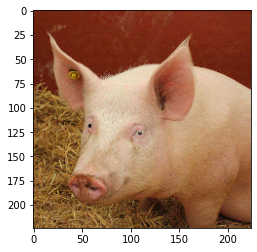

Predicted: [('n02095570', 'Lakeland_terrier', 0.071640916), ('n01883070', 'wombat', 0.03912965), ('n02098286', 'West_Highland_white_terrier', 0.03329992)]


In [41]:
# Let's see!
# ResNet50
perturb_image("pig.jpg", 341, 189, resnet50)

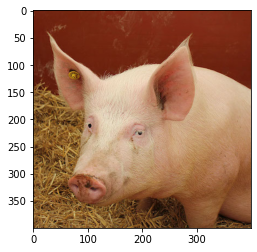

Predicted before adv.: [('n02395406', 'hog', 0.89816827), ('n02396427', 'wild_boar', 0.032517917), ('n01704323', 'triceratops', 0.0011955537)]
0 9.718162
20 8.155922
40 6.9120436
60 5.862198
80 4.947228
100 4.1286736
120 3.3891973
140 2.7236857
160 2.1251092
180 1.5838461
200 1.092659
220 0.645741
240 0.23918676
260 -0.13598728
280 -0.49377155
300 -0.8464885
320 -1.2048893
340 -1.5811405


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


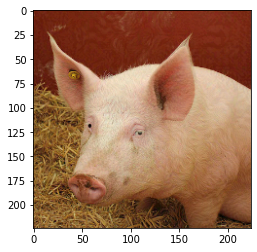

Predicted: [('n02114548', 'white_wolf', 0.15369064), ('n02134084', 'ice_bear', 0.074162506), ('n02115641', 'dingo', 0.014918477)]


In [42]:
# Let's see!
# EfficientNetB0 (ImageNet)
perturb_image("pig.jpg", 341, 189, enb0)

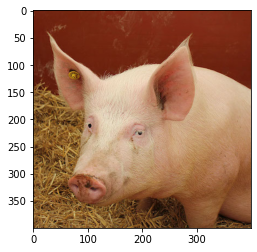

Predicted before adv.: [('n02395406', 'hog', 0.9445952), ('n02396427', 'wild_boar', 0.024054553), ('n02397096', 'warthog', 0.00050586456)]
0 10.3168
20 8.709769
40 7.249504
60 5.9480124
80 4.634706
100 3.1899545
120 1.8353848
140 0.8424554
160 -0.12234259
180 -1.253808
200 -2.1485853
220 -2.7055655
240 -3.0940657
260 -3.432479
280 -3.7733498
300 -4.128995
320 -4.4905887
340 -4.851984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


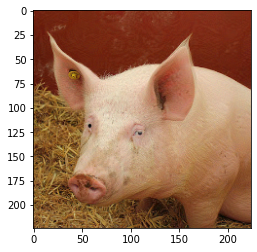

Predicted: [('n01498041', 'stingray', 0.51840883), ('n01496331', 'electric_ray', 0.29736176), ('n02655020', 'puffer', 0.007815107)]


In [43]:
# Let's see!
# EfficientNetB0 (Noisy Student Training)
perturb_image("pig.jpg", 341, 189, enb0_nst)

We are successful here as well. Let's see if we could do the same for the `Lakeland_terrier` image we saw earlier i.e. fool the classifier to believe that the image is of a hog.

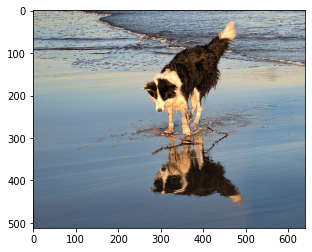

Predicted before adv.: [('n02095570', 'Lakeland_terrier', 0.3143305), ('n02102040', 'English_springer', 0.18979445), ('n02101388', 'Brittany_spaniel', 0.18742307)]
0 14.960787
20 9.918959
40 6.098837
60 3.2015429
80 0.856534
100 0.0
120 0.0
140 0.0
160 1.9073486e-06
180 0.0
200 0.0
220 0.0
240 0.0
260 0.0
280 0.0
300 0.0
320 0.0
340 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


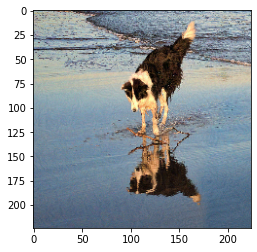

Predicted: [('n02102040', 'English_springer', 0.48360687), ('n02106166', 'Border_collie', 0.34620807), ('n02109525', 'Saint_Bernard', 0.07557377)]


In [ ]:
perturb_image("example.jpg", 189, 341)

You see in this case, we could not get there but the classifier still yields wrong predicitions. May be we would need to train the system harder. Finally, let's see how our classifier does on an image constructed with random pixel values within `[0,255]` range. 

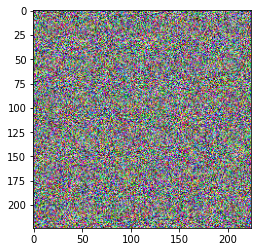

In [ ]:
# Generate a random image and run predictions
random_image = np.random.uniform(low=0, high=255, size=(224,224,3)).astype("int")
plt.imshow(random_image)
plt.show()

Let's save it first so that we can reproduce it if we want to. 

In [ ]:
# Serialize the random image
cv2.imwrite("random.png", random_image)

True

In [ ]:
# Let's first see what our classifier thinks of this 
preprocessed_image = preprocess_image(plt.imread("random.png"))
preds = resnet50.predict(preprocessed_image)
print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

Predicted: [('n06359193', 'web_site', 0.06508517), ('n03196217', 'digital_clock', 0.044688992), ('n01930112', 'nematode', 0.043546457)]


The classifier thinks it to be a `web_site`. Can we make it believe that it is a `hog`? Let's see!

In [ ]:
# Let's get the class index for `tennis_ball` first
for key, value in imagenet_classes.items():
    if imagenet_classes[key] == "web_site":
        print(key)

916


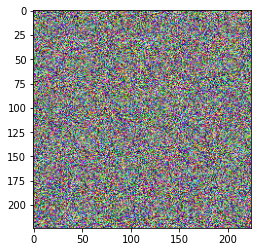

Predicted before adv.: [('n06359193', 'web_site', 0.06508517), ('n03196217', 'digital_clock', 0.044688992), ('n01930112', 'nematode', 0.043546457)]
0 7.1632943
20 6.5041842
40 6.1241045
60 5.731626
80 5.3543406
100 4.951699
120 4.5134706
140 4.0862756
160 3.6255307
180 3.0830097
200 2.5463924
220 2.1069345
240 1.7077804
260 1.3375049
280 0.97974634
300 0.599143
320 0.11381912
340 -0.3797531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


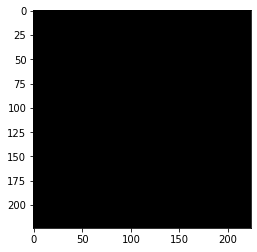

Predicted: [('n04590129', 'window_shade', 0.37725896), ('n04589890', 'window_screen', 0.05656971), ('n09229709', 'bubble', 0.036282938)]


In [ ]:
# And ...
perturb_image("random.png", 916, 341)

A couple of observations here:
- When we tried to launch a targeted attack we failed at generating similar looking example and also failed at fooling the classifier to believe that it belong to the class of our choice. May be more rigorous training would have helped here (at least the losses tell so) but we are not sure since there is no structure in the pixels in the first place. 